/var/folders/fj/3dsy68bx2v56pml4k75_pv180000gn/T/ipykernel_46301/2661801298.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


Note: 'Adj Close' not found, using 'Close' instead.
Simulation complete.

OPTIMAL PORTFOLIO WEIGHTS (Max Sharpe):
MSFT: 0.0000
JPM: 0.4700
TLT: 0.3070
GLD: 0.2229
BTC-USD: 0.0000

Daily Value at Risk (95% Confidence): -1.31%
Meaning: With 95% confidence, the portfolio will not lose more than 1.31% in a single day.


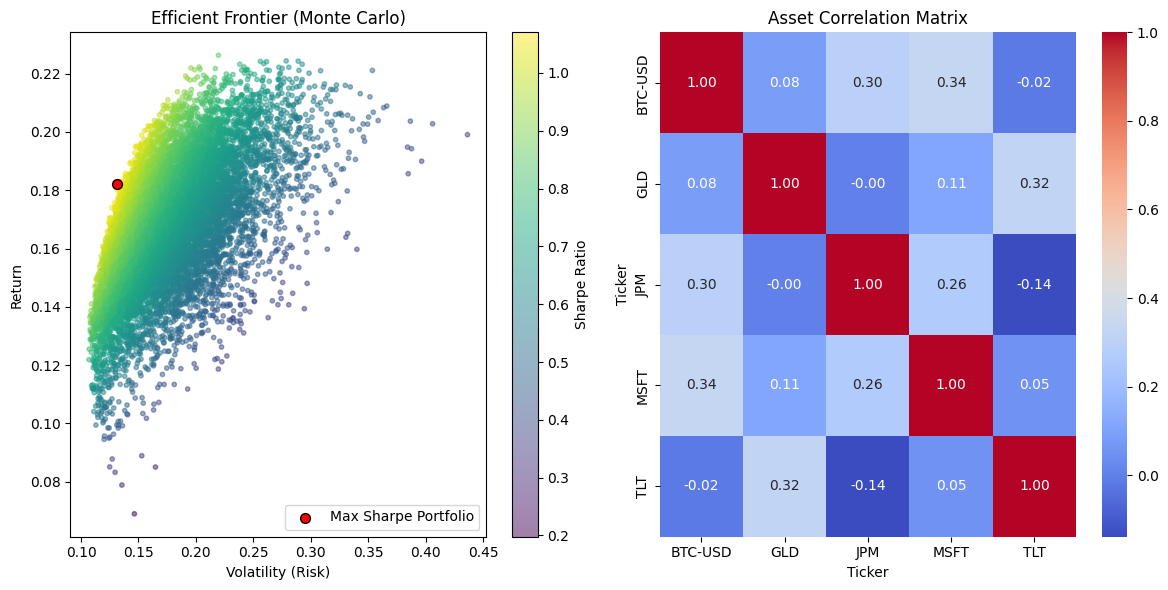

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

tickers = ['MSFT', 'JPM', 'TLT', 'GLD', 'BTC-USD']
start_date = '2021-01-01'
end_date = '2025-01-01'

print(f"Downloading data for {tickers}...")
raw_data = yf.download(tickers, start=start_date, end=end_date)

if 'Adj Close' in raw_data.columns.levels[0]:
    data = raw_data['Adj Close']
else:
    print("Note: 'Adj Close' not found, using 'Close' instead.")
    data = raw_data['Close']

log_returns = np.log(data / data.shift(1)).dropna()

num_simulations = 10000
all_weights = np.zeros((num_simulations, len(tickers)))
ret_arr = np.zeros(num_simulations)
vol_arr = np.zeros(num_simulations)
sharpe_arr = np.zeros(num_simulations)

risk_free_rate = 0.04 

for i in range(num_simulations):
    weights = np.array(np.random.random(len(tickers)))
    weights = weights / np.sum(weights) 
    all_weights[i,:] = weights

    ret_arr[i] = np.sum(log_returns.mean() * weights) * 252
    
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    
    sharpe_arr[i] = (ret_arr[i] - risk_free_rate) / vol_arr[i]

print("Simulation complete.")

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sr = (ret - risk_free_rate) / vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))
init_guess = [1/len(tickers) for _ in range(len(tickers))]

opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = opt_results.x
print("\nOPTIMAL PORTFOLIO WEIGHTS (Max Sharpe):")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_returns = log_returns.dot(optimal_weights)
    
var_95 = np.percentile(optimal_portfolio_returns, 5)
print(f"\nDaily Value at Risk (95% Confidence): {var_95:.2%}")
print(f"Meaning: With 95% confidence, the portfolio will not lose more than {abs(var_95*100):.2f}% in a single day.")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', s=10, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.title('Efficient Frontier (Monte Carlo)')
opt_ret, opt_vol, opt_sr = get_ret_vol_sr(optimal_weights)
plt.scatter(opt_vol, opt_ret, c='red', s=50, edgecolors='black', label='Max Sharpe Portfolio')
plt.legend()

plt.subplot(1, 2, 2)
sns.heatmap(log_returns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Asset Correlation Matrix')

plt.tight_layout()
plt.savefig('Portfolio_Optimization_Model.png', dpi=300)
plt.show()